# Tutorial Notebook: Analysis workflow for single-cell-resolved interaction data with the Boosting Autoencoder (BAE)

This Jupyter notebook demonstrates a workflow for analyzing interaction patterns of single-cell cell-cell interaction (CCI) data with the [Boosting Autoencoder (BAE)](https://github.com/NiklasBrunn/BoostingAutoencoder). 


### The workflow is devided in five main steps:

- [Setup](#Setup)
- [Load the gene expression data](#Load-the-gene-expression-data)
- [Construct a CCIM with NICHES](#Construct-a-CCIM-with-NICHES)
- [Perform the BAE analysis of the CCIM](#Perform-the-BAE-analysis-of-the-CCIM)
- [Result visualization and data saving](#Result-visualization-and-data-saving)

Based on either single-cell RNA sequencing (scRNA-seq) or spatial transcriptomics (ST) data, we chose [NICHES](https://github.com/msraredon/NICHES) for reconstructing CCIs based on known ligand-receptor interactions from the [FANTOM5](https://fantom.gsc.riken.jp/5/) or [OmniPath](https://omnipathdb.org) database. The reconstructed CCIs are shape of a cel-cell interaction matrix (CCIM), where observations correspond to cell pairs representing edges in a directed communication graph, where nodes correspond to cells. The features of the CCIM are the selected ligand-receptor interactions by NICHES and represent the edge features in the communication graph.
The resulting CCIM can then be passed to the BAE for interaction pattern analysis of cell pairs. 


To run the workflow you can either use one of the example data that can be loaded within the notebook or load and process your own single-cell RNA sequencing (scRNA-seq) or spatial transcriptomics (ST) data. In the [Load the gene expression data](#Load-the-gene-expression-data) section, we describe how the example data can be loaded for an exemplary analysis, as well as provide details about how to load and prepare your own data for the analysis.

The notebook is written in [Julia v1.9.3](#https://julialang.org/downloads/oldreleases/). Since NICHES is implemented using the R programming language, we provide wrapper functions for calling NICHES directly in this notebook through julia functions.

## Setup:

First you can activate the Julia environment and load all required packages for running the interaction pattern analysis workflow. Calling the following cell for the first time will download and precompile all the required packages and this may take a few minutes.

In [1]:
#---Activate the enviroment:
using Pkg;

Pkg.activate("../");
Pkg.instantiate();
Pkg.status()

#---Set the path to the project:
projectpath = joinpath(@__DIR__, "../"); 

#---Load the BoostingAutoEncoder module:
include(projectpath * "/src/BAE.jl");
using .BoostingAutoEncoder

#---Load required packages for this notebook:
using RCall;
using DelimitedFiles;
using Plots;
using Random;
using StatsBase;
using VegaLite;  
using DataFrames;
using StatsPlots;

  Activating project at `~/Documents/Projects/Applications_Notes_BAE/Sparse-dimension-reduction`


Status `~/Documents/Projects/Applications_Notes_BAE/Sparse-dimension-reduction/Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [336ed68f] CSV v0.10.14
  [aaaa29a8] Clustering v0.15.7
⌃ [35d6a980] ColorSchemes v3.25.0
  [a93c6f00] DataFrames v1.6.1
  [b4f34e82] Distances v0.10.11
⌃ [587475ba] Flux v0.14.15
⌃ [91a5bcdd] Plots v1.40.4
⌃ [92933f4c] ProgressMeter v1.10.0
⌃ [6f49c342] RCall v0.14.1
  [2913bbd2] StatsBase v0.34.3
  [f3b207a7] StatsPlots v0.15.7
  [c4f8c510] UMAP v0.1.11
  [112f6efa] VegaLite v3.3.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


Next, you can set the path to the directory, where the data that you want to analyze is located and specify, where you want to save the results. Per default, there are two folders created by running the following code cell, one for loading and storing the analyzed data and one for storing the created result figures. However, you can alternatively change the paths below.

In [2]:
#---Set paths to the data directory and the figures directory:

# Set the path to the data directory and create the folder if it does not already exist 
# (exchange the path below with the path to your data directory):
datapath = projectpath * "data/tutorial/";
if !isdir(datapath)
    mkdir(datapath)
end

# Set the path to the figures directory and create the folder if it does not already exist 
# (exchange the path below with the path to where you want to store your results):
figurespath = projectpath * "figures/tutorial/"
if !isdir(figurespath)
    mkdir(figurespath)
end

## Load the gene expression data:

In this section you can either choose to run the analysis workflow with some example data (scRNA-seq or ST) or upload your own data. 

Currently, the following options are supported:

- We provide access to two different example data set that were also used as an example in the [NICHES paper](https://academic.oup.com/bioinformatics/article/39/1/btac775/6865029). The first example data is [scRNA-seq data from rat lungs](#A.-Starting-with-the-scRNA-seq-example-data) (A). The second example data is [spot-based ST data from the mouse cortex](#B.-Starting-with-the-ST-example-data) (B).

- Since NICHES is already implemented in R and part of our proposed workflow, you can alternatively start by [directly running NICHES on your data](#C.-Starting-with-an-own-Seurat-object) if it is already stored as a Seurat object (C).

- In case you have your data stored as an anndata object or in another format, another option to run the workflow is to [manually extract and load the gene expression matrix, the relevant meta data and the gene names](#D.-Starting-with-own-data-from-other-sources-and-preparing-for-the-signaling-pattern-analysis-workflow) (D). 

### A. Starting with the scRNA-seq example data:

As a first example you can load [rat lung scRNA-seq data](#https://www.science.org/doi/10.1126/sciadv.aaw3851) from [https://zenodo.org/record/6846618/files/raredon_2019_rat.Robj](#https://zenodo.org/record/6846618/files/raredon_2019_rat.Robj), which was also used in the original NICHES publication. You can download directly and save the data locally as a Seurat object by running the following cell without the need of downloading the data manually. To save the data to another directory, you can specify a path in the `data_path` argument of the `load_rat_scRNAseq_data()` function.

For the cell-cell interation pattern analysis workflow with the BAE, we follow the steps of the [R vignette](#https://github.com/msraredon/NICHES/blob/master/vignettes/02%20NICHES%20Single.Rmd) provided by the NICHE authors and subset the data to consist only of the cell types that are known to be spatially close to each other. However, you can also acsess the whole data by setting `subset_data=false` in the `load_rat_scRNAseq_data()` function. 
The data is already preprocessed including cell- and gene filtering, as well as normalization and transformation. In addition, [ALRA](#https://www.nature.com/articles/s41467-021-27729-z) imputation was applied to impute missing values. 

When downloading the data for the first time, it may take a few minutes. If the data has already been downloaded and a file with the downloaded data already exists in the directory where the data is stored, the download will be skipped.

In [3]:
#---Load example scRNA-seq data:
# Download a subset of the example rat lung data from "https://zenodo.org/record/6846618/files/raredon_2019_rat.Robj" and save it to the data directory:
tSNE_embedding, celltypes = load_rat_scRNAseq_data(; transfer_data=true)[[2, 3]];

# Alternatively, you can download the full dataset by setting subset_data=false and define another directory for saving the data):
#tSNE_embedding, celltypes = load_rat_scRNAseq_data(; data_path=datapath, subset_data=false, transfer_data=true);

┌ Warning: The file already exists. Skipping the download ...
└ @ Main.BoostingAutoEncoder /Users/niklasbrunn/Documents/Projects/Applications_Notes_BAE/Sparse-dimension-reduction/src/utils.jl:356
┌ Warning: RCall.jl: Warnung: Paket 'Seurat' wurde unter R Version 4.3.3 erstellt
│ Lade n"otiges Paket: SeuratObject
│ Warnung: Paket 'SeuratObject' wurde unter R Version 4.3.3 erstellt
│ Lade n"otiges Paket: sp
│ 
│ Attache Paket: 'SeuratObject'
│ 
│ Die folgenden Objekte sind maskiert von 'package:base':
│ 
│     intersect, t
│ 
└ @ RCall /Users/niklasbrunn/.julia/packages/RCall/dDAVd/src/io.jl:172


Transferring the data to Julia ...


┌ Warning: RCall.jl: Warnung: The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
│ i Please use the `layer` argument instead.
│ Warnung in asMethod(object)
│   sparse->dense coercion: allocating vector of size 1.1 GiB
└ @ RCall /Users/niklasbrunn/.julia/packages/RCall/dDAVd/src/io.jl:172


Data transfer completed.


(Float32[11.383455 1.6029067; 13.235134 -8.971994; … ; 14.951315 -19.601156; 13.400301 -27.933064], ["ATII", "ATI", "ATI", "Mac_alv", "ATII", "EC_vasc", "EC_vasc", "Mac_alv", "EC_vasc", "Mac_alv"  …  "ATII", "ATI", "ATII", "Mac_alv", "ATII", "ATII", "ATII", "SMCs", "ATI", "ATI"])

For demonstration purposes, you can visualize the data using the pre-computed [tSNE](#https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) coordinates in the Seurat object. Note that tSNE was run on the entire data, but only the cells of the selected types are shown here.

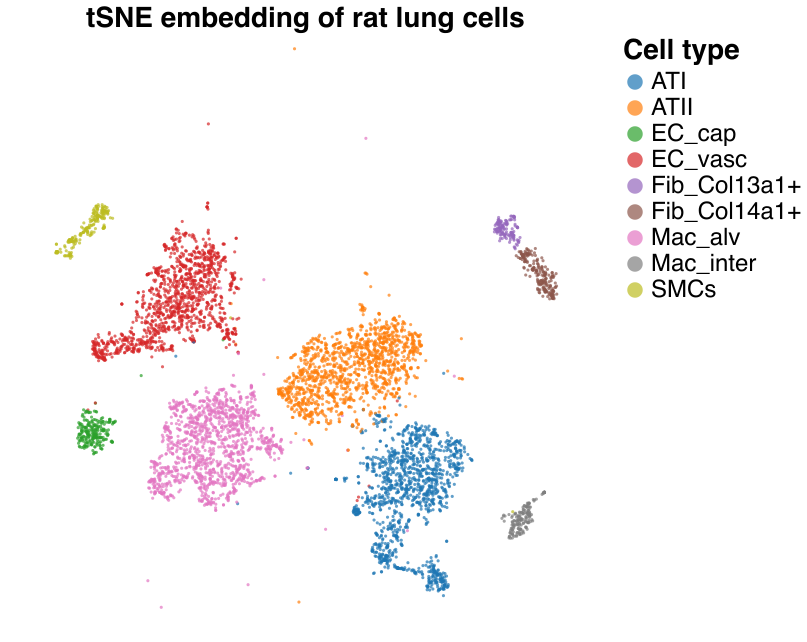

In [4]:
#---Plot the UMAP embedding of the learned BAE latent representation colored by the cluster labels:
vegascatterplot(tSNE_embedding, celltypes; 
    path=figurespath * "ratLung_data_tSNE.png",
    legend_title="Cell type",
    Title="tSNE embedding of rat lung cells",
    color_field="labels:o",
    scheme="category10",
    domain_mid=nothing,
    range=nothing,
    save_plot=true,
    marker_size="10"
)

### B. Starting with the ST example data:

`ToDo:`

You can also use data from a ST experiment for the interaction pattern analysis workflow. As an example you can load the [10X Visium mouse brain data](#) 

When downloading the data for the first time, it may take a few minutes! If the data has already been downloaded and a file with the downloaded data already exists in the directory where the data is stored, the download will be skipped.

In [ ]:
#---Load example ST data:
# Download the example spatial mouse brain Visium data accessible via SeuratData and save it to the data directory:
load_spatial_mousebrain_data();

### C. Starting with an own Seurat object:

If your scRNA-seq or ST data is already stored in a Seurat object, then you can already start the analysis and continue with running NICHES to construct a CCIM.
Please make sure that cell type annotations are available in the meta.data of your Seurat object (in case of scRNA-seq data), because NICHES requires them for the subsampling process.

- >Continue by [running NICHES](#Construct-a-CCIM-with-NICHES) on your data to construct a CCIM.

### D. Starting with own data from other sources and preparing for the signaling pattern analysis workflow:

`ToDo:`

In case you have your data in another format, which is not a Seurat object, currently as part of the workflow, we will construct a Seurat object with your data that can then be handed as input to the NICHES algorithm for constructing a CCIM.

In [ ]:
#---Tasic data CCIM construction:
other_source_data = false;
if other_source_data
    X_norm_hvg = readdlm(datapath * "../cortical_mouse/corticalMouseDataMat_allgenes_log1.txt", Float32);
    genenames = vec(readdlm(datapath * "../cortical_mouse/genenames.txt", String));
    celltypes = vec(readdlm(datapath * "../cortical_mouse/celltype.txt", String));

    # Alternatively:
    #df = that consists of the cell_ids in a column and the (normalized) counts (cells x genes) in the other columns. Can be taken as input to the create_seurat_object function.

    #---Summarize meta data information:
    MD = MetaData(; featurename=genenames);
    MD.obs_df[!, :Celltype] = celltypes;


    #---Create a Seurat object:
    create_seurat_object(X_norm_hvg', MD; 
        data_path=nothing, 
        file_name=nothing,
        assay= "RNA",
        normalize_data=false, 
        alra_imputation=false,
        indents="Celltype",
        data_is_normalized=true
    );
end

## Construct a CCIM with NICHES:

`ToDo:`

NICHES can be used to compute CCIMs representing cell-to-cell communication. Alternatively, CCIMs can be constructed that represent cell-to-system or system-to-cell communiication. Each observation corresponds to a pair that represents either a cell pair with a sender and a receiver cell, a pair with a sender cell and a receiver system, or a sender system and a receiver cell.

...

In [ ]:
#---Run NICHES on scRNA-seq data:
#filepath_expData = datapath * "Rat_Seurat_sub.rds";
#run_NICHES_wrapper(filepath_expData; data_path=nothing, alra_imputation=false, assay="alra", species="rat", LR_database="fantom5", cell_types="cell_types");

#---Run NICHES on ST data:
filepath_expData = datapath * "MouseBrain_Seurat.rds";
run_NICHES_wrapper(filepath_expData;
    alra_imputation=true, 
    assay="alra",
    species="mouse",
    cell_types="seurat_clusters",
    position_x="x",
    position_y="y",
    n_neighbors=4,
    meta_data_to_map=["orig.ident","seurat_clusters"],
    CellToCell=false,
    SystemToCell=false,
    CellToSystem=false,
    CellToCellSpatial=false,
    NeighborhoodToCell=true,
    CellToNeighborhood=false,
);

#---Run NICHES on other data:
#filepath_expData = datapath * "Seurat_object.rds";
#run_NICHES_wrapper(filepath_expData; data_path=nothing, alra_imputation=true, assay="alra", species="mouse", LR_database="fantom5", cell_types="Celltype");

## Perform the BAE analysis of the CCIM:

`ToDo:`

### A. Loading and preprocessing the NICHES CCIM for the BAE analysis:

...

In [ ]:
#---Load the NICHES results:
#filepath_CCIM = datapath * "NICHES_CellToCell.rds";
#CCIM, CCIM_st, MD = load_CCIM_CtC(filepath_CCIM); #CellToCell

#filepath_CCIM = datapath * "NICHES_SystemToCell.rds";
#CCIM, CCIM_st, MD = load_CCIM_StC(filepath_CCIM); #SystemToCell

#filepath_CCIM = datapath * "NICHES_CellToSystem.rds";
#CCIM, CCIM_st, MD = load_CCIM_CtS(filepath_CCIM); #CellToSystem


#---Load spatial NICHES results:
#filepath_CCIM = datapath * "NICHES_CellToCell_Spatial.rds";
#CCIM, CCIM_st, MD = load_CCIM_CtC_Spatial(filepath_CCIM); #CellToCell (spatial)

filepath_CCIM = datapath * "NICHES_NeighborhoodToCell.rds";
CCIM, CCIM_st, MD = load_CCIM_NtC(filepath_CCIM); #NeighborhoolToCell (spatial)

#filepath_CCIM = datapath * "NICHES_CellToNeighborhood.rds";
#CCIM, CCIM_st, MD = load_CCIM_CtN(filepath_CCIM); #CellToNeighborhood (spatial)

### B. Set hyperparameters for the BAE training:

Befor we train a BAE on the data, we need to specify the hyperparameters for training. 
...

In [ ]:
#---Define hyperparameters for training a BAE:
#HP = Hyperparameters(zdim=30, n_restarts=3, epochs=20, batchsize=2^11, η=0.01, λ=0.1, ϵ=0.01, M=1);# Rat lung scRNA-seq data
HP = Hyperparameters(zdim=15, n_restarts=3, epochs=100, batchsize=2^9, η=0.01, λ=0.1, ϵ=0.01, M=1); # Spatial mouse brain data 
#HP = Hyperparameters(zdim=8, n_restarts=3, epochs=50, batchsize=2^9, η=0.01, λ=0.1, ϵ=0.01, M=1); #Mouse brain scRNA-seq data

#---Hyperparameters for reconstructing the published results:
#HP = Hyperparameters(zdim=30, n_restarts=1, epochs=2000, batchsize=2^12, η=0.01, λ=0.1, ϵ=0.001, M=1); 

### C. Define the neural network architecture for the BAE:

Next, we create the neural network architecture for the BAE. 
...

In [ ]:
#---Define the decoder architecture:
p = size(CCIM_st, 2);
decoder = generate_BAEdecoder(p, HP; soft_clustering=true);

#---Initialize the BAE model:
BAE = BoostingAutoencoder(; coeffs=zeros(Float32, p, HP.zdim), decoder=decoder, HP=HP);
summary(BAE)

### D. Train the BAE:

We are now ready to train the model.

In [ ]:
#---Train the BAE model:
@time begin
    output_dict = train_BAE!(CCIM_st, BAE; MD=MD, track_coeffs=true, save_data=false, path=nothing);
end

@info "Minimum Trainloss at: $(argmin(output_dict["trainloss"]))"

## Result visualization and data saving:

`ToDo:`

In [ ]:
#---Generate a custom color scheme of distinct colors:
n_cols = 2 * BAE.HP.zdim; 
custom_colorscheme = [hsl_to_hex(i / n_cols, 0.7, 0.5 + 0.1 * sin(i * 4π / BAE.HP.zdim)) for i in 1:n_cols]; 
custom_colorscheme_shuffled = shuffle(custom_colorscheme);

#----Compute 2D UMAP embedding of the learned BAE latent representation and add to the metadata:
BAE.UMAP = generate_umap(BAE.Z');
MD.obs_df[!, :UMAP1] = BAE.UMAP[:, 1];
MD.obs_df[!, :UMAP2] = BAE.UMAP[:, 2];

In [ ]:
#---Plot the mean trainloss per epoch:
mean_trainlossPerEpoch = output_dict["trainloss"];
loss_plot = plot(1:length(mean_trainlossPerEpoch), mean_trainlossPerEpoch,
     title = "Mean train loss per epoch",
     xlabel = "Epoch",
     ylabel = "Loss",
     legend = true,
     label = "Train loss",
     linecolor = :red,
     linewidth = 2
);
savefig(loss_plot, figurespath * "/Trainloss_BAE.png");
loss_plot

In [ ]:
#---Plot the Sparsity score per epoch:
sparsity_level = output_dict["sparsity"];
loss_plot = plot(1:length(sparsity_level), sparsity_level,
     title = "Sparsity level per epoch",
     xlabel = "Epoch",
     ylabel = "Sparsity",
     legend = true,
     label = "Sparsity",
     linecolor = :orange,
     linewidth = 2
);
savefig(loss_plot, figurespath * "/Sparsity_BAE.png");
loss_plot

In [ ]:
#---Plot the disentanglement score per epoch:
entanglement_score = output_dict["entanglement"];
loss_plot = plot(1:length(entanglement_score), entanglement_score,
     title = "Entanglement score per epoch",
     xlabel = "Epoch",
     ylabel = "Entanglement of dimensions",
     legend = true,
     label = "Entanglement",
     linecolor = :orange,
     linewidth = 2
);
savefig(loss_plot, figurespath * "/Entanglement_BAE.png");
loss_plot

In [ ]:
#---Plot the clustering score per epoch:
clustering_score = output_dict["clustering"];
loss_plot = plot(1:length(clustering_score), clustering_score,
     title = "Clustering score per epoch",
     xlabel = "Epoch",
     ylabel = "Clustering score",
     legend = true,
     label = "Score",
     linecolor = :orange,
     linewidth = 2
);
savefig(loss_plot, figurespath * "/ClusteringScore_BAE.png");
loss_plot

In [ ]:
#---Create scatter plots of the top selected genes per latent dimension:
if !isdir(figurespath * "/TopFeaturesLatentDim")
    # Create the folder if it does not exist
    mkdir(figurespath * "/TopFeaturesLatentDim")
end
for dim in 1:BAE.HP.zdim
    Featurescatter_plot = normalizedFeatures_scatterplot(BAE.coeffs[:, dim], MD.featurename, dim; top_n=10)
    savefig(Featurescatter_plot, figurespath * "/TopFeaturesLatentDim/" * "BAE_dim$(dim)_topInteractions.png")
end

In [ ]:
#---Create scatter plots of the top selected genes per cluster:
if !isdir(figurespath * "/TopFeaturesCluster")
    # Create the folder if it does not exist
    mkdir(figurespath * "/TopFeaturesCluster")
end
for key in keys(MD.Top_features)
    if length(MD.Top_features[key].Scores) > 0
        FeatureScatter_plot = TopFeaturesPerCluster_scatterplot(MD.Top_features[key], key; top_n=10)
        savefig(FeatureScatter_plot, figurespath * "/TopFeaturesCluster/" * "BAE_Cluster$(key)_Interactions.png")
    end
end

In [ ]:
#---Plot the absolute values of Pearson correlation coefficients between latent dimensions:
vegaheatmap(abs.(cor(BAE.Z, dims=2)); 
    path=figurespath * "cor_latentDimensions_BAE.png", 
    Title="Absolute correlations of latent dimensions",
    xlabel="Latent dimension", 
    ylabel="Latent dimension",
    legend_title="Value",
    scheme="orangered",
    domain_mid=nothing,
    save_plot=true,
    Width=500, 
    Height=500
)

In [ ]:
#---Plot the spearman correlation between the latent dimensions:
vegaheatmap(abs.(corspearman(BAE.Z')); 
    path=figurespath * "spearman_cor_latentDimensions_BAE.png", 
    Title="Absolute Spearman rank correlations of latent dimensions",
    xlabel="Latent dimension", 
    ylabel="Latent dimension",
    legend_title="Value",
    scheme="orangered",
    domain_mid=nothing,
    save_plot=true,
    Width=500, 
    Height=500
)

In [ ]:
#---Plot boxplots of the latent activations of cells per latent dimension:
plot_row_boxplots(BAE.Z; xlabel="Latent dimension", ylabel="Cell activation", saveplot=true, path=figurespath * "/BAE_Z_boxplot.png")

In [ ]:
#---Plot a heatmap of the cluster probabilities of cells:
Cluster_df = DataFrame(BAE.Z_cluster', :auto);
Cluster_df[!, :Cluster] = copy(MD.obs_df.Cluster);
sort!(Cluster_df, :Cluster);

#ClusterProbabilities_plot = heatmap(Matrix(Cluster_df[:, 1:end-1]), ylabel="Cell", title="Cluster probabilities", color=:dense, xlabel="Cluster", size=(700, 500));
#savefig(ClusterProbabilities_plot, figurespath * "/clusterProbabilities_BAE_plots.svg");

vegaheatmap(Matrix(Cluster_df[:, 1:end-1]); #!Currently does not work if zdim > 30 ... (in that case use the heatmap function from Plots.jl above)
    path=figurespath * "clusterProbabilities_BAE.png", 
    Title="Cluster probabilities of cells",
    xlabel="Cluster", 
    ylabel="Cell",
    legend_title="Probability",
    scheme="purpleblue",
    domain_mid=nothing,
    save_plot=true
)

In [ ]:
#---Plot the UMAP embedding of the learned BAE latent representation of cell pairs colored by the sending-receiving type pair:
if "CellTypePair" in names(MD.obs_df)
    pl = vegascatterplot(Matrix(MD.obs_df[:, [:UMAP1, :UMAP2]]), MD.obs_df.CellTypePair; 
        path=figurespath * "CellTypePair_(BAE)umap.png",
        legend_title="Sender-Receiver",
        color_field="labels:o",
        scheme=nothing,
        domain_mid=nothing,
        range=custom_colorscheme_shuffled,
        save_plot=true,
        marker_size="5"
    )

    display(pl)
    
else
    @warn "CellTypePair not found in metadata!"
end

In [ ]:
#---Plot the UMAP embedding of the learned BAE latent representation colored by the cluster labels:
vegascatterplot(Matrix(MD.obs_df[:, [:UMAP1, :UMAP2]]), MD.obs_df.Cluster; 
    path=figurespath * "Cluster_(BAE)umap.png",
    legend_title="Cluster",
    color_field="labels:o",
    scheme=nothing,
    domain_mid=nothing,
    range=custom_colorscheme_shuffled,
    save_plot=true,
    marker_size="5"
)

In [ ]:
#---Plot the UMAP embedding of the learned BAE latent representation colored by the sender cell types:
if "SenderType" in names(MD.obs_df)
    pl = vegascatterplot(Matrix(MD.obs_df[:, [:UMAP1, :UMAP2]]), MD.obs_df.SenderType; 
        path=figurespath * "SenderType_(BAE)umap.png",
        legend_title="Sender",
        color_field="labels:o",
        scheme="category20",
        domain_mid=nothing,
        range=nothing, #custom_colorscheme[[1, 3, 14, 26, 31, 36, 42, 45, 53]],
        save_plot=true,
        marker_size="5"
    )

    display(pl)
    
else
    @warn "MetaData has no column named: SenderType."
end

In [ ]:
#---Plot the UMAP embedding of the learned BAE latent representation colored by the sender cell types:
if "ReceiverType" in names(MD.obs_df)
    pl = vegascatterplot(Matrix(MD.obs_df[:, [:UMAP1, :UMAP2]]), MD.obs_df.ReceiverType; 
        path=figurespath * "ReceiverType_(BAE)umap.png",
        legend_title="Receiver",
        color_field="labels:o",
        scheme="category20",
        domain_mid=nothing,
        range=nothing, #custom_colorscheme[[1, 3, 14, 26, 31, 36, 42, 45, 53]],
        save_plot=true,
        marker_size="5"
    )

    display(pl)
    
else
    @warn "MetaData has no column named: ReceiverType."
end

In [ ]:
#---Create scatter plots of the UMAP embedding of the learned BAE latent representation colored by activations in different latent dimensions:
if !isdir(figurespath * "/UMAPplotsLatDims")
    # Create the folder if it does not exist
    mkdir(figurespath * "/UMAPplotsLatDims")
end
create_colored_vegascatterplots(Matrix(MD.obs_df[:, [:UMAP1, :UMAP2]]), BAE.Z;
    path=figurespath * "/UMAPplotsLatDims/",
    filename="Rat_BAE_dim",
    filetype="scatter.png",
    legend_title="Activation",
    color_field="labels:q",
    scheme="blueorange", 
    domain_mid=0,
    range=nothing,
    save_plot=true,
    marker_size="10"
)

In [ ]:
#---Create scatter plots of the UMAP embedding of the learned BAE latent representation colored by activations for different clusters:
if !isdir(figurespath * "/UMAPplotsCluster")
    # Create the folder if it does not exist
    mkdir(figurespath * "/UMAPplotsCluster")
end
#Bright color:
#color_range = [
#    "#fff5f5", "#ffe0e0", "#ffcccc", "#ffb8b8", "#ffa3a3", "#ff8f8f", "#ff7a7a", "#ff6666",
#    "#ff5252", "#ff3d3d", "#ff2929", "#ff1414", "#ff0000", "#e50000", "#cc0000", "#b20000",
#    "#990000", "#7f0000", "#660000", "#4c0000", "#330000"
#];
#Dark color:
color_range = [
    "#000000", "#220022", "#440044", "#660066", "#880088", "#aa00aa", "#cc00cc", "#ee00ee",
    "#ff00ff", "#ff19ff", "#ff33ff", "#ff4cff", "#ff66ff", "#ff7fff", "#ff99ff", "#ffb2ff",
    "#ffccff", "#ffe5ff", "#ffccf5", "#ff99eb", "#ff66e0"
]
create_colored_vegascatterplots(Matrix(MD.obs_df[:, [:UMAP1, :UMAP2]]), BAE.Z_cluster;
    path=figurespath * "/UMAPplotsCluster/",
    filename="Rat_BAE_dim",
    filetype="scatter.png",
    legend_title="Activation",
    color_field="labels:q",
    scheme=nothing, 
    domain_mid=nothing,
    range=color_range,
    save_plot=true,
    marker_size="10"
)

In [ ]:
#---Create scatter plots of the UMAP embedding of the learned BAE latent representation colored by expression levels of top selected genes for different clusters:
if !isdir(figurespath * "/FeaturePlots")
    # Create the folder if it does not exist
    mkdir(figurespath * "/FeaturePlots")
end
#Bright color:
#color_range = [
#    "#fff5f5", "#ffe0e0", "#ffcccc", "#ffb8b8", "#ffa3a3", "#ff8f8f", "#ff7a7a", "#ff6666",
#    "#ff5252", "#ff3d3d", "#ff2929", "#ff1414", "#ff0000", "#e50000", "#cc0000", "#b20000",
#    "#990000", "#7f0000", "#660000", "#4c0000", "#330000"
#];
#Dark color:
color_range = [
    "#000000", "#220022", "#440044", "#660066", "#880088", "#aa00aa", "#cc00cc", "#ee00ee",
    "#ff00ff", "#ff19ff", "#ff33ff", "#ff4cff", "#ff66ff", "#ff7fff", "#ff99ff", "#ffb2ff",
    "#ffccff", "#ffe5ff", "#ffccf5", "#ff99eb", "#ff66e0"
]
FeaturePlots(MD.Top_features, MD.featurename, CCIM, Matrix(MD.obs_df[:, [:UMAP1, :UMAP2]]); 
    top_n=5,
    marker_size="10", 
    fig_type=".png",
    path=figurespath * "/FeaturePlots/",
    legend_title="log1p",
    color_field="labels:q",
    scheme=nothing, 
    domain_mid=nothing,
    range=color_range
)

In [ ]:
#---Create a coefficient plots for visually inspecting coefficient update trajectories for the last run of the training:
if haskey(output_dict, "coefficients")
    if !isdir(figurespath * "/CoefficientsPlots")
        # Create the folder if it does not exist
        mkdir(figurespath * "/CoefficientsPlots")
    end
    for dim in 1:BAE.HP.zdim
        pl = track_coefficients(output_dict["coefficients"], dim; iters=nothing, xscale=:log10)
        savefig(pl, figurespath * "/CoefficientsPlots/CoefficientsPlot_BAE_dim$(dim).png")
    end
else 
    @warn "No coefficient trajectories were saved during training."
end